Author: Neven Caplar and the LINCC Frameworks team

Last updated: July 08, 2025

# Lightcurves in Rubin Collections

In this tutorial, you will learn:

- Crossmatch custom list of positions
- How to access Object and diaObject data
- Show lightcurves for both Objects and diaObjects

## Visualize periodic lightcurves in Rubin data

In [17]:
import astropy.units as u
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lsdb
import dask

from dask.distributed import Client
from io import StringIO
from nested_pandas import NestedDtype
from pathlib import Path

import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configuration settings
rcParams["savefig.dpi"] = 550
rcParams["font.size"] = 20
plt.rc("font", family="serif")
mpl.rcParams["axes.linewidth"] = 2
warnings.simplefilter("ignore")
logging.getLogger("numexpr.utils").setLevel(logging.WARNING)
logging.getLogger("distributed").setLevel(logging.WARNING)
dask.config.set({"dataframe.convert-string": False})

Rubin data are organized in so-called ``collections``. A collection is the logical container for a group of catalogs that belong together. This often corresponds to a data release, a processing run, or a particular science product family. What this means for you is that you dont have to specify margin catalogs explicity (as we had to do in Notebook 1); the margin catalog is already preloaded for you.

In [2]:
PATH_OBJ = "/rubin/lsdb_data/object_collection/"
PATH_DIA_OBJ = "/rubin/lsdb_data/dia_object_collection/"
obj_catalog = lsdb.open_catalog(PATH_OBJ)
dia_catalog = lsdb.open_catalog(PATH_DIA_OBJ)

When you open a catalog in LSDB using lsdb.open_catalog, it initializes the catalog by reading only its metadata and schema—not the actual data—unless explicitly requested. In this case, out of 1304 total columns in the catalog, only 42 have been loaded lazily, meaning LSDB has registered their existence and structure, but no data has been read from disk for those columns yet. This lazy-loading behavior improves performance and memory efficiency, especially when dealing with large catalogs, by deferring I/O operations until a computation or filtering action requires access to the actual column values.

In [3]:
obj_catalog

,coord_dec,coord_decErr,coord_ra,coord_raErr,g_psfFlux,g_psfFluxErr,g_psfMag,g_psfMagErr,i_psfFlux,i_psfFluxErr,i_psfMag,i_psfMagErr,objectId,patch,r_psfFlux,r_psfFluxErr,r_psfMag,r_psfMagErr,refBand,refFwhm,shape_flag,shape_xx,shape_xy,shape_yy,tract,u_psfFlux,u_psfFluxErr,u_psfMag,u_psfMagErr,x,xErr,y,y_psfFlux,y_psfFluxErr,y_psfMag,y_psfMagErr,yErr,z_psfFlux,z_psfFluxErr,z_psfMag,z_psfMagErr,objectForcedSource
npartitions=389,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 6, Pixel: 130",double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<coord_ra: [double], coord_dec: [double]..."
"Order: 8, Pixel: 2176",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2302101",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 143884",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Choose the variable objects

We have a selection of 10 variable objects, which were found from previous analysis of forced photometry on science images. At this point we can consider these as object from a separate catalog that we have loaded.

In [4]:
variables_csv = \
"""ra,dec,period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""
variables_df = pd.read_csv(StringIO(variables_csv)).reset_index()

# Transform the DataFrame into a LSDB Catalog. Not necesarry to crossmatch, but to showcase the ability to do so.
variables_catalog = lsdb.from_dataframe(variables_df)
variables_catalog

,index,ra,dec,period
npartitions=2,,,,
"Order: 2, Pixel: 80",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 5, Pixel: 8582",...,...,...,...


In [5]:
XMATCH_RADIUS_ARCSEC = 0.2
variable_object = variables_catalog.crossmatch(
    obj_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_var", ""]
)
variable_dia = variables_catalog.crossmatch(
    dia_catalog, radius_arcsec=XMATCH_RADIUS_ARCSEC, suffixes=["_var", ""]
)
# The result will have all the columns in obj_catalog suffixed with `_obj`,
# all the columns in dia_catalog suffixed with `_dia`, as well as all the
# columns in `variables_df` suffixed with `_var_obj`
result = variable_object.join(
    variable_dia, left_on="index_var", right_on="index_var", suffixes=["_obj", "_dia"]
)

And apply filtering according to the quality flags using the `query` method[^query].

[^query]: See the `Catalog.query` documentation: https://docs.lsdb.io/en/latest/reference/api/lsdb.catalog.Catalog.query.html#lsdb.catalog.Catalog.query

In [6]:
for column in ["objectForcedSource_obj", "diaSource_dia", "diaObjectForcedSource_dia"]:
    result = result.query(
        f"~{column}.psfFlux_flag"
        f" and ~{column}.pixelFlags_saturated"
        f" and ~{column}.pixelFlags_cr"
        f" and ~{column}.pixelFlags_bad"
    )
result

,index_var_obj,ra_var_obj,dec_var_obj,period_var_obj,coord_dec_obj,coord_decErr_obj,coord_ra_obj,coord_raErr_obj,g_psfFlux_obj,g_psfFluxErr_obj,g_psfMag_obj,g_psfMagErr_obj,i_psfFlux_obj,i_psfFluxErr_obj,i_psfMag_obj,i_psfMagErr_obj,objectId_obj,patch_obj,r_psfFlux_obj,r_psfFluxErr_obj,r_psfMag_obj,r_psfMagErr_obj,refBand_obj,refFwhm_obj,shape_flag_obj,shape_xx_obj,shape_xy_obj,shape_yy_obj,tract_obj,u_psfFlux_obj,u_psfFluxErr_obj,u_psfMag_obj,u_psfMagErr_obj,x_obj,xErr_obj,y_obj,y_psfFlux_obj,y_psfFluxErr_obj,y_psfMag_obj,y_psfMagErr_obj,yErr_obj,z_psfFlux_obj,z_psfFluxErr_obj,z_psfMag_obj,z_psfMagErr_obj,objectForcedSource_obj,_dist_arcsec_obj,index_var_dia,ra_var_dia,dec_var_dia,period_var_dia,dec_dia,diaObjectId_dia,nDiaSources_dia,ra_dia,radecMjdTai_dia,tract_dia,diaObjectForcedSource_dia,diaSource_dia,_dist_arcsec_dia
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 8, Pixel: 329721",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],float[pyarrow],bool[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],"nested<coord_ra: [double], coord_dec: [double]...",double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<band: [string], coord_dec: [double], co...","nested<band: [string], centroid_flag: [bool], ...",double[pyarrow]
"Order: 9, Pixel: 1324352",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197038",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 9, Pixel: 2197120",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
with Client(n_workers=4, threads_per_worker=1) as client:
    # Sort light curves by variable object index for plotting purposes
    result_df = result.compute().sort_values("index_var_obj")

In [8]:
# ok, now we have our resulting df with all the possible columns
result_df 

index_var_obj  ra_var_obj  dec_var_obj  period_var_obj  \
_healpix_29                                                                   
1456157018405184225              0    94.95546    -24.73952         0.12095   
1450131236226156835              1    95.30235    -25.27431         0.12248   
1456157750233453047              2    94.91626    -24.69648         0.12038   
1456145241786549427              3    95.12418    -25.04329         0.23554   
2415759959093266587              4    58.83506    -48.79122         0.56335   
1456140633585049253              5    94.92264    -25.23185         0.07672   
1456149791804243835              6    94.72086    -25.05767         0.17559   
2415669000192289034              8    59.12997    -48.78522         0.11628   
1456149791804243835              9    94.72086    -25.05767         0.17554   

                     coord_dec_obj  coord_decErr_obj  coord_ra_obj  \
_healpix_29                                                          
1456157018405184225     -24.739524               0.0     94.955465   
1450131236226156835     -25.274306               0.0     95.302354   
1456157750233453047     -24.696482               0.0      94.91626   
1456145241786549427     -25.043288               0.0     95.124185   
2415759959093266587     -48.791216               0.0     58.835057   
1456140633585049253     -25.231852               0.0     94.922636   
1456149791804243835     -25.057669               0.0     94.720857   
2415669000192289034     -48.785224               0.0     59.129967   
1456149791804243835     -25.057669               0.0     94.720857   

                     coord_raErr_obj  g_psfFlux_obj  g_psfFluxErr_obj  ...  \
_healpix_29                                                            ...   
1456157018405184225              0.0   96215.617188         40.481762  ...   
1450131236226156835              0.0   38424.933594         34.274925  ...   
1456157750233453047              0.0   333769.84375         75.333427  ...   
1456145241786549427              0.0     1447216.25        131.617188  ...   
2415759959093266587              0.0  227908.046875         62.881378  ...   
1456140633585049253              0.0  114717.398438         40.412148  ...   
1456149791804243835              0.0    234904.0625         57.171268  ...   
2415669000192289034              0.0   15816.786133         24.092821  ...   
1456149791804243835              0.0    234904.0625         57.171268  ...   

                     period_var_dia    dec_dia     diaObjectId_dia  \
_healpix_29                                                          
1456157018405184225         0.12095 -24.739521  614437746487853390   
1450131236226156835         0.12248 -25.274309  614435616184074426   
1456157750233453047         0.12038 -24.696486  614438502402097162   
1456145241786549427         0.23554 -25.043283  614436990573609020   
2415759959093266587         0.56335 -48.791213  592913981740417050   
1456140633585049253         0.07672 -25.231851  614435753623027782   
1456149791804243835         0.17559 -25.057664  614429019114307699   
2415669000192289034         0.11628 -48.785226  592913913020940296   
1456149791804243835         0.17554 -25.057664  614429019114307699   

                     nDiaSources_dia     ra_dia  radecMjdTai_dia  tract_dia  \
_healpix_29                                                                   
1456157018405184225              201  94.955459     60656.341913       5526   
1450131236226156835               97  95.302351     60656.341097       5526   
1456157750233453047              191  94.916259     60656.341913       5526   
1456145241786549427              190  95.124193     60656.341913       5526   
2415759959093266587              207  58.835037     60655.279809       2394   
1456140633585049253              186  94.922635     60656.341913       5526   
1456149791804243835              180  94.720857     60656.341097       5525   
2415669000192289034              152  5

In [25]:
COLORS = {"u": "blue", "g": "green", "r": "red", "i": "orange", "z": "purple", "y": "brown"}

In [26]:
def plot_mag_lightcurves(ax, row):
    """Plot magnitude light curves from DIA source and forcedSource"""
    datasets = [
        ("scienceFlux", "diaSourceTable_tract", row.diaSource_dia),
        ("psfFlux", "forcedSourceTable", row.objectForcedSource_obj),
    ]
    all_mags = [[], []]  # To store magnitudes for each row
    for i, (flux_col, table_name, lc) in enumerate(datasets):
        title = f"{flux_col} from {table_name}"
        flux_err_col = f"{flux_col}Err"
        ax[0, i].set_title(title)
        # Compute phase
        lc = lc.assign(
            phase=(lc.midpointMjdTai - lc.midpointMjdTai.loc[lc.psfFlux.idxmax()])
            % row.period_var_obj
            / row.period_var_obj
        )
        # First row: original light curve
        all_mags[0].extend(
            plot_mag_scale(
                ax[0, i],
                lc,
                flux_col,
                flux_err_col,
                x_name="midpointMjdTai",
                x_label="MJD",
                show_legend=(i == 0),
            )
        )
        # Second row: folded light curve
        all_mags[1].extend(
            plot_mag_scale(
                ax[1, i],
                lc,
                flux_col,
                flux_err_col,
                x_name="phase",
                x_label="Phase",
                show_legend=(i == 0),
            )
        )
    return all_mags


def plot_mag_scale(ax, lc, flux_col, flux_err_col, x_name, x_label, show_legend=False):
    """Plot light curves in magnitude scale with enhanced styling per band"""
    mag_values = []  # Store magnitudes for setting axis limits
    for band, color in COLORS.items():
        band_lc = lc.query(f"band == '{band}'")
        if band_lc.empty:
            continue
        mag, magErr = create_mag_errors(band_lc[flux_col], band_lc[flux_err_col])
        ax.errorbar(
            band_lc[x_name],
            mag,
            yerr=magErr,
            fmt="o",
            label=band,
            color=color,
            ecolor=color,
            elinewidth=1,
            capsize=2,
            alpha=0.8,
            markeredgecolor="k",
            markersize=8,
        )
        mag_values.extend(mag.dropna().values)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude")
    ax.invert_yaxis()
    ax.grid(True)
    if show_legend:
        ax.legend(title="Band", loc="best", fontsize=12)
    return mag_values


def create_mag_errors(sciFlux, sciFluxErr):
    """Convert flux to magnitudes and compute magnitude error"""
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux + sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux - sciFluxErr)
    magErr = -(upper_mag - lower_mag) / 2
    return mag, magErr


def scale_mag_y_axis(ax, all_mags):
    """Set uniform y-axis scaling for each plot row"""
    for row_idx in range(2):
        if all_mags[row_idx]:
            ymin, ymax = np.nanmin(all_mags[row_idx]), np.nanmax(all_mags[row_idx])
            for i in range(2):
                ax[row_idx, i].set_ylim(ymax + 0.1, ymin - 0.1)

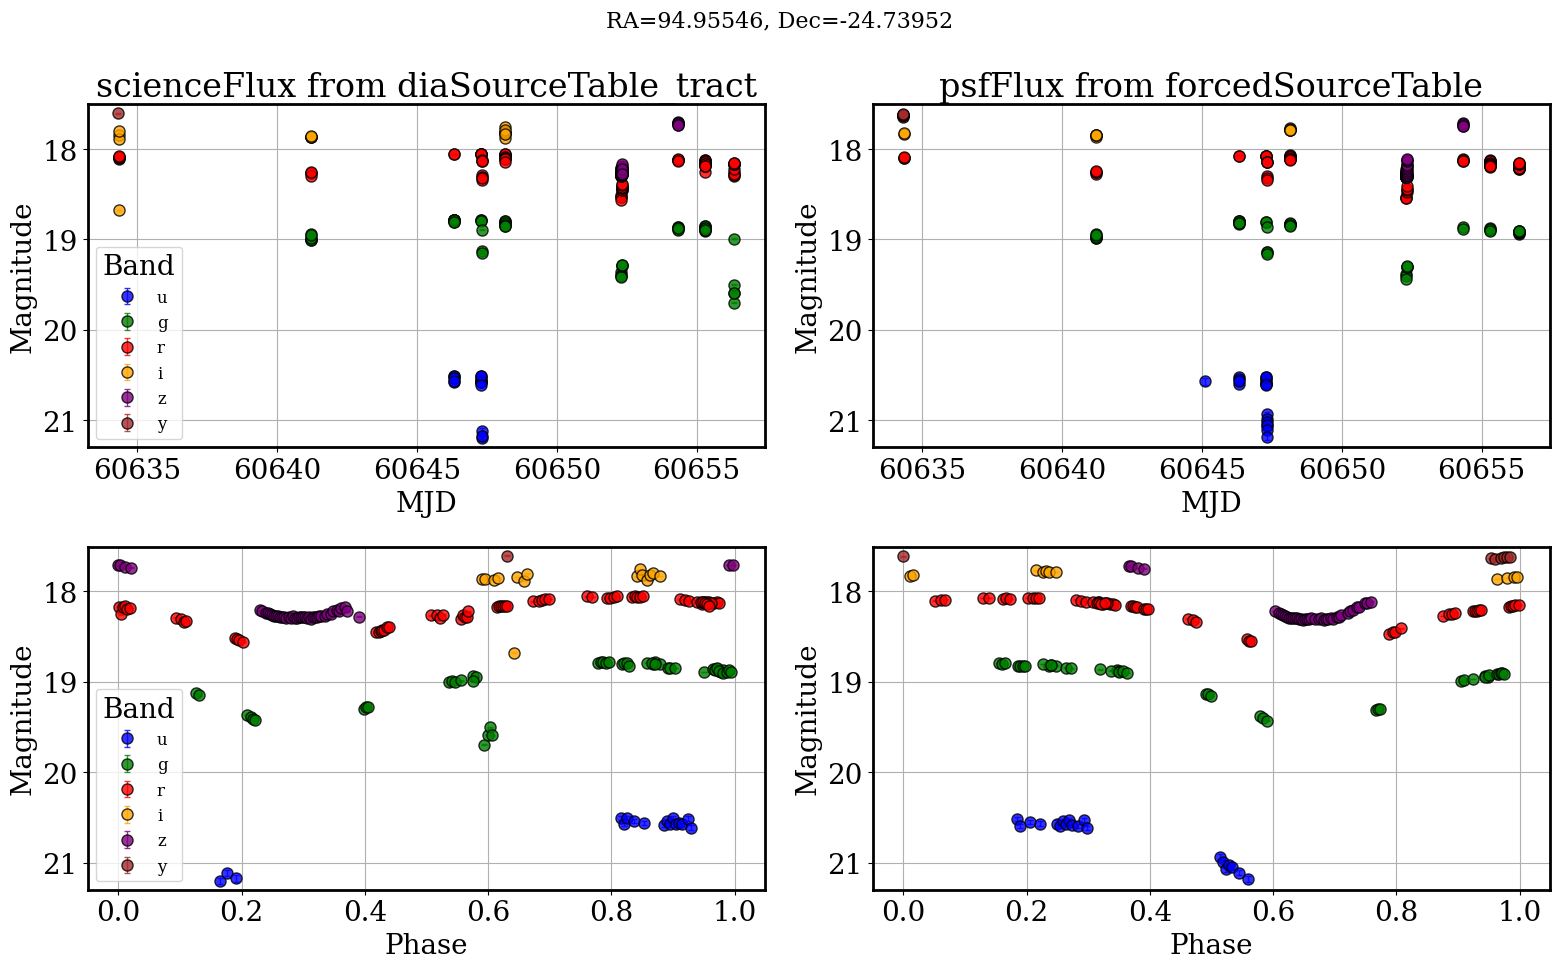

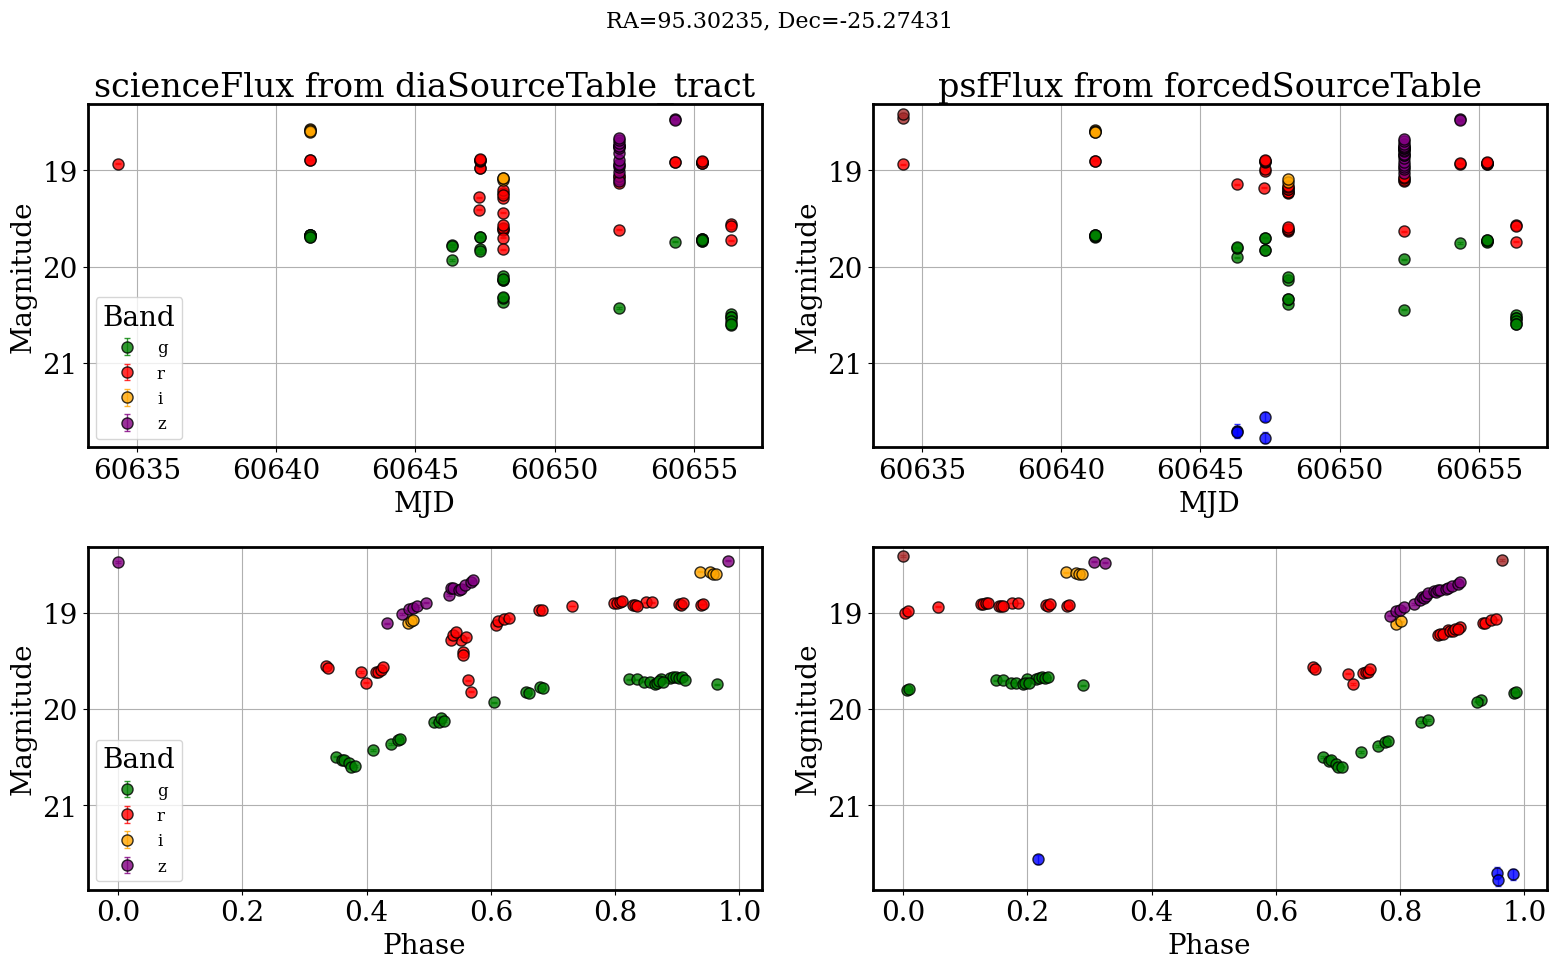

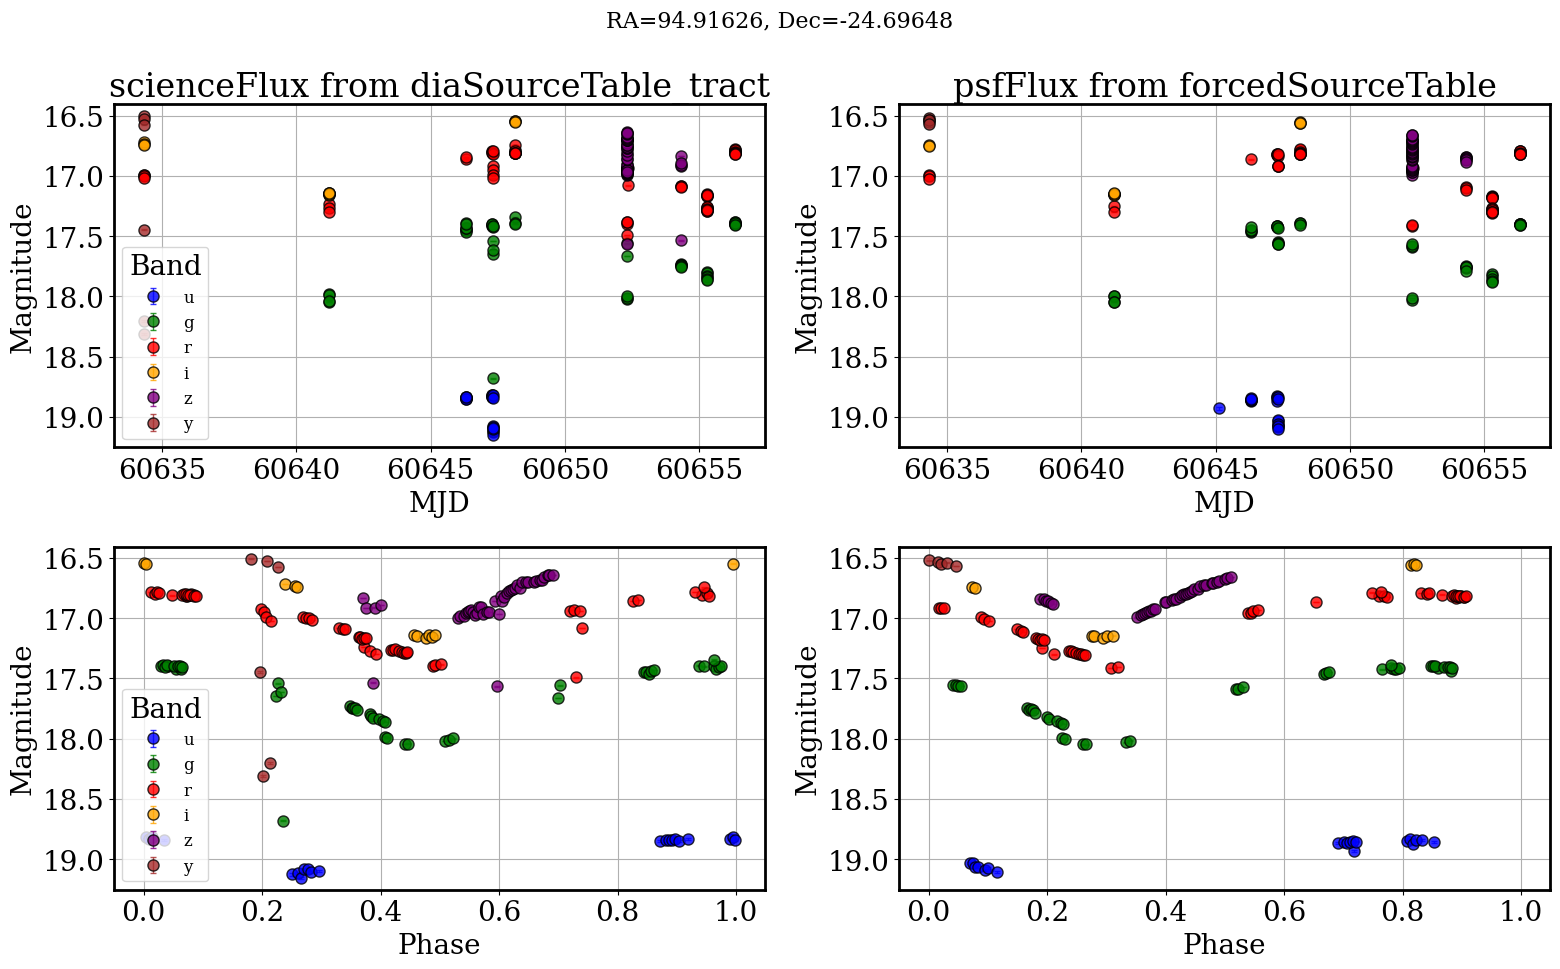

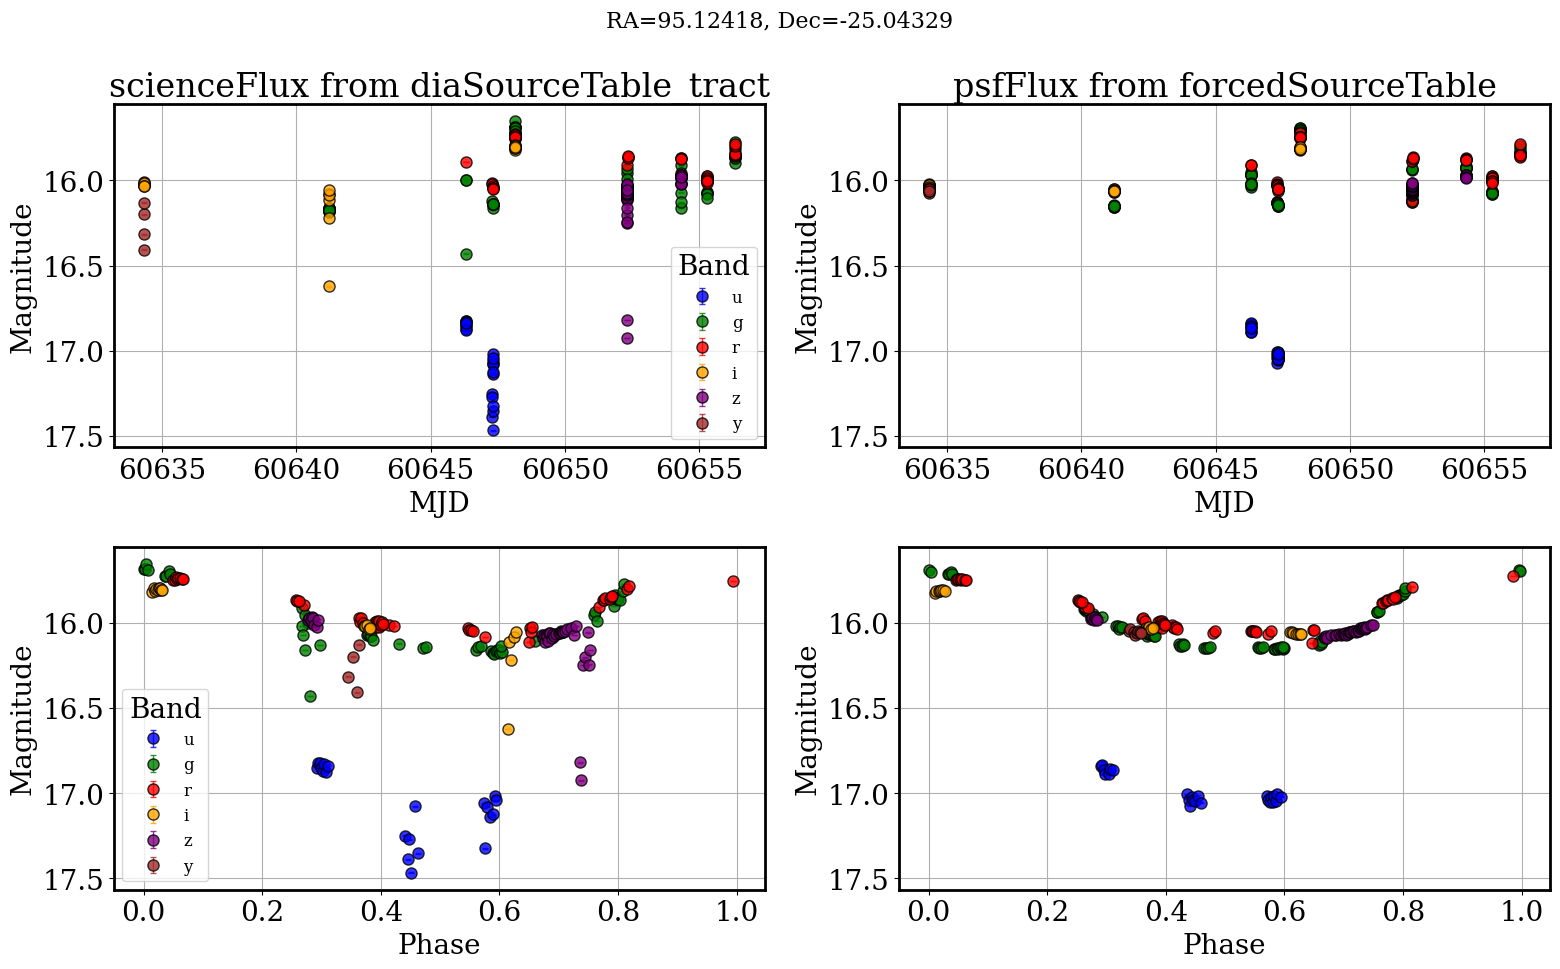

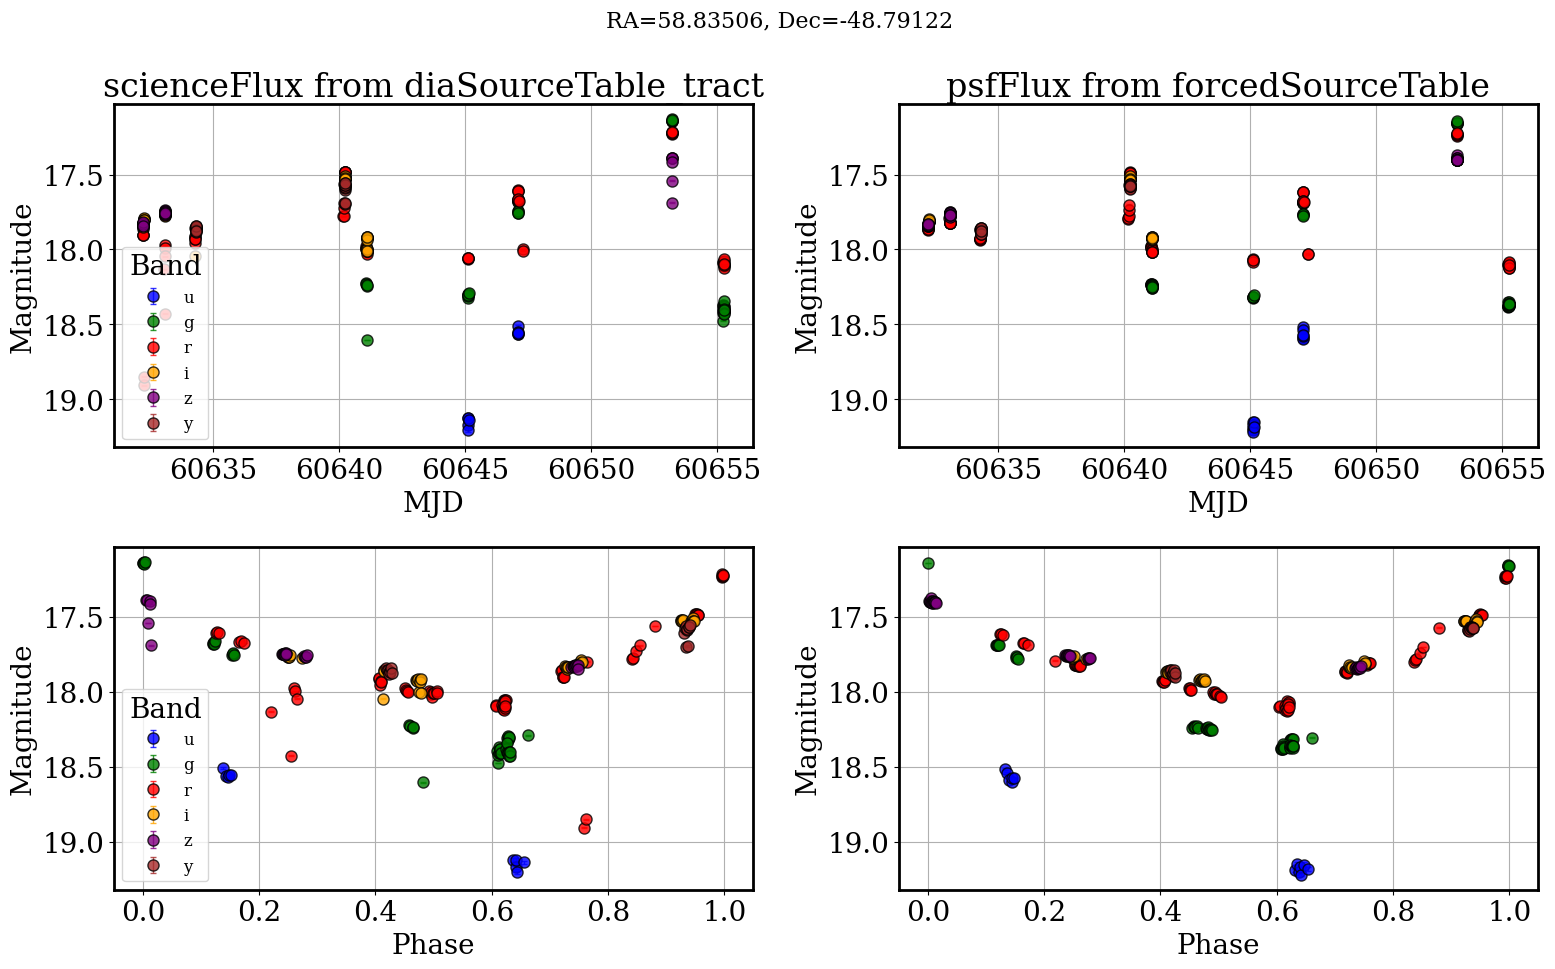

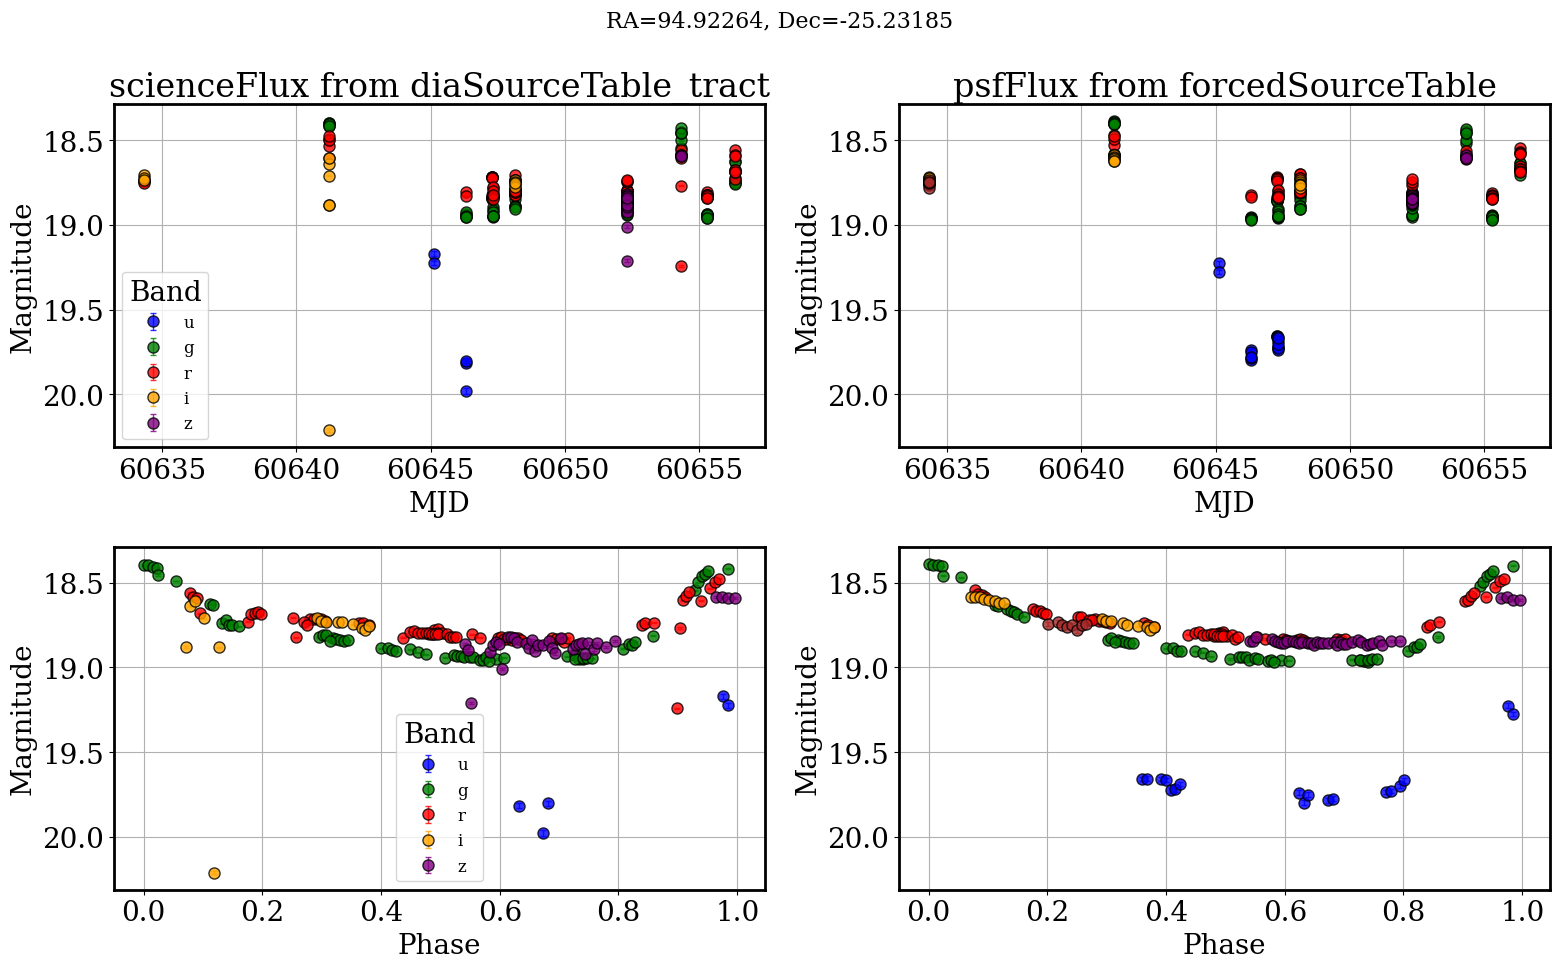

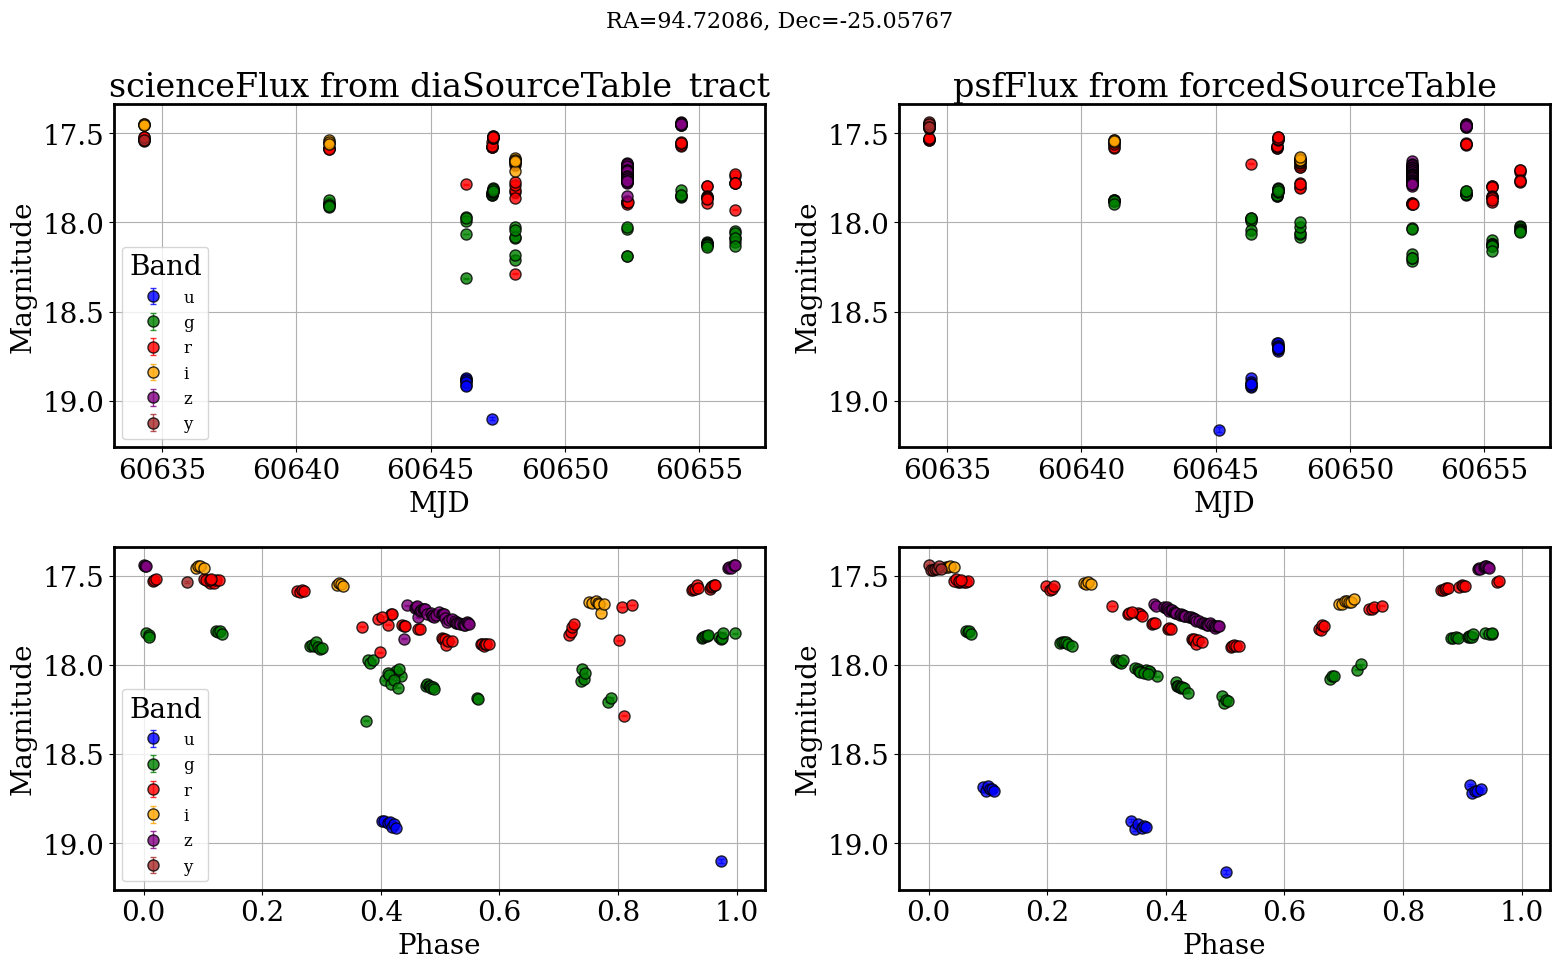

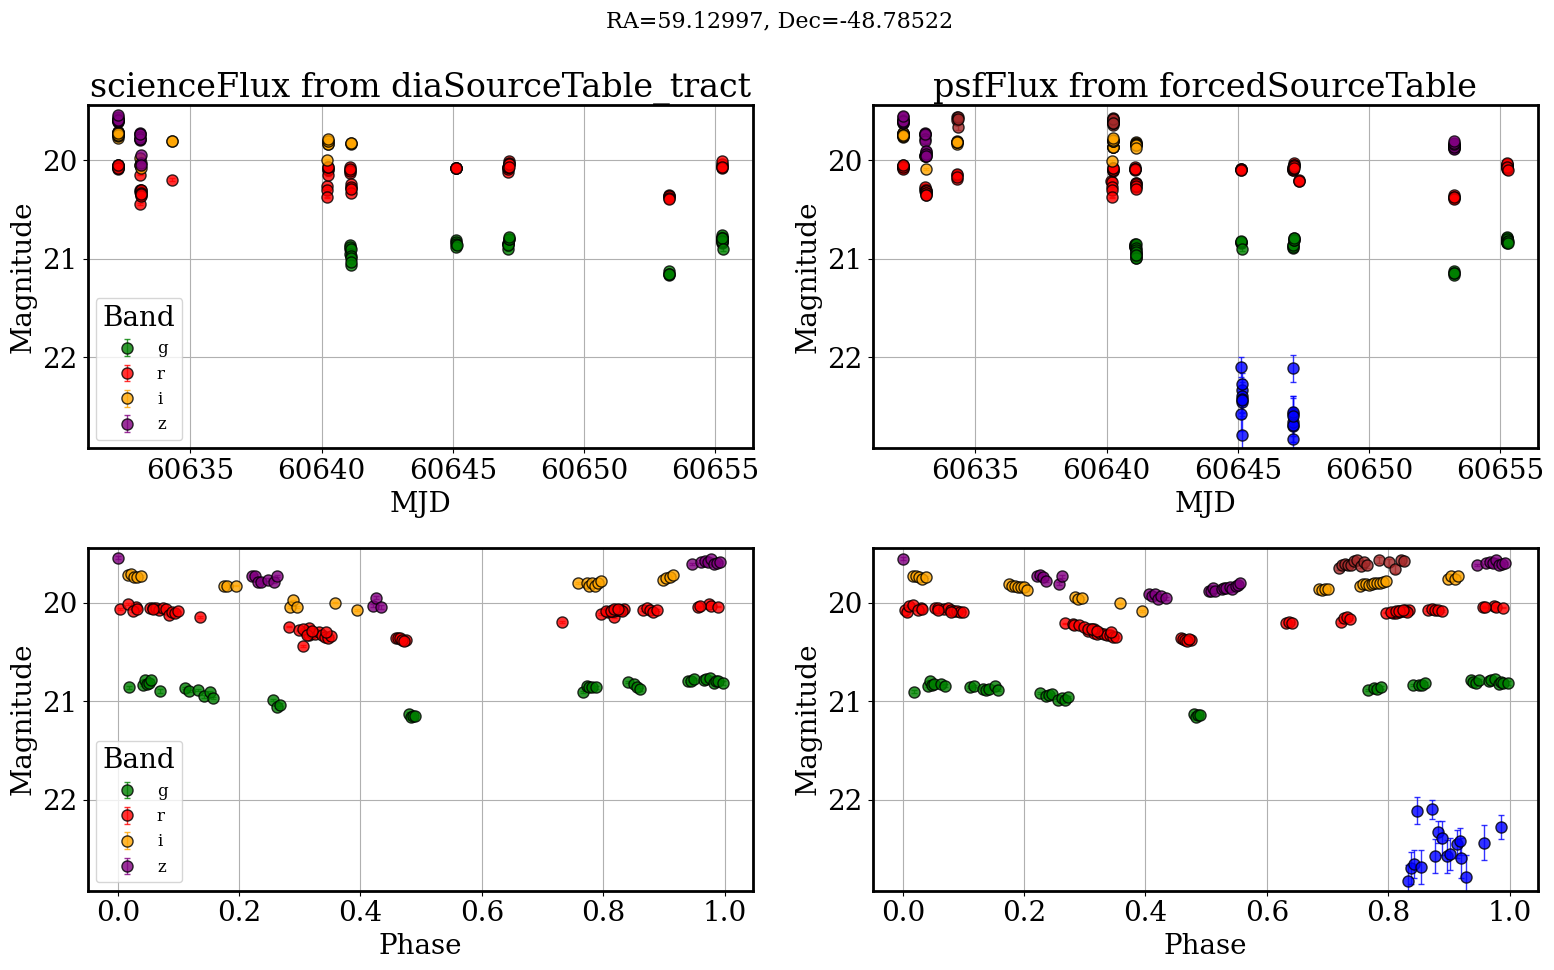

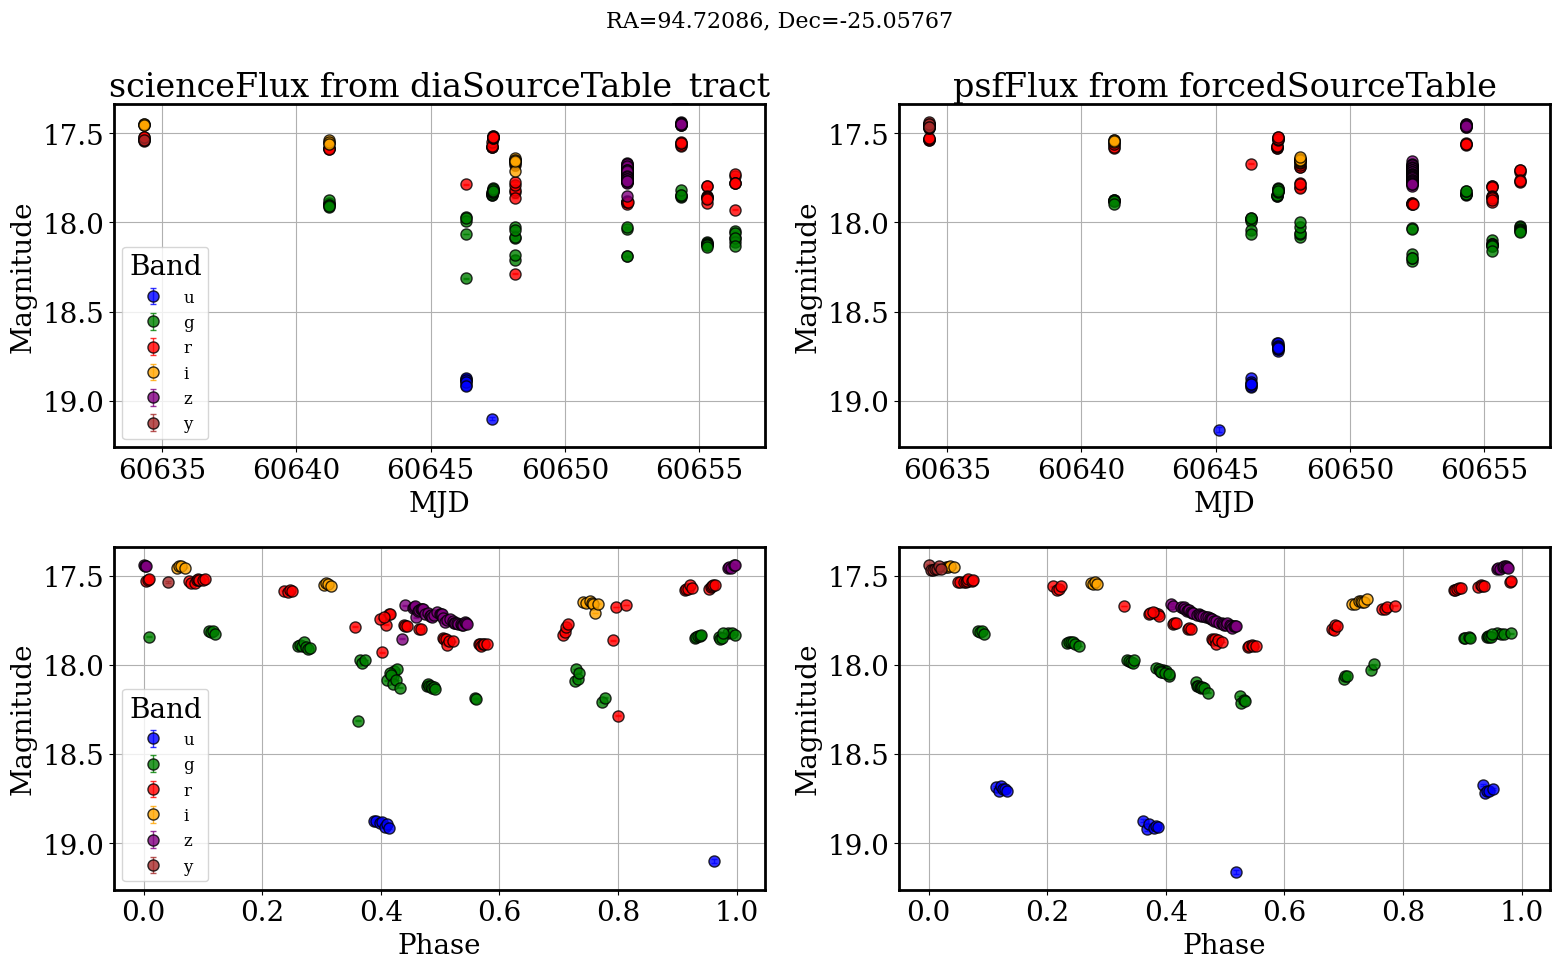

In [27]:
for _, row in result_df.iterrows():
    fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex="row")  # 2 rows, 2 columns
    fig.suptitle(
        f"RA={row.ra_var_obj:.5f}, Dec={row.dec_var_obj:.5f}",
        fontsize=16,
    )
    all_mags = plot_mag_lightcurves(ax, row)
    scale_mag_y_axis(ax, all_mags)
    plt.tight_layout()
    plt.show()

# Problem 4

## Find interesting objects from Rubin in ZTF

Ok, we found these 10 interesting objects in Rubin data. Are they in any other dataset. How about data from Zwicky Transient Facility!
LSDB has ave various ZTF datasets, e.g., https://data.lsdb.io/#ZTF/ZTF_DR22 
- How many of these objects are avaliable in ZTF? 
- Are you able to create folded lightcurve for those?